# 1. 라이브러리, 데이터 로드

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

from xgboost import XGBClassifier

# -----------------------------
# 1) 데이터 불러오기
# -----------------------------
train = pd.read_csv("datas_ml/train.csv")
test  = pd.read_csv("datas_ml/test.csv")

TARGET_COL = "target"
ID_COL = "id"

y = train[TARGET_COL]
X = train.drop([TARGET_COL, ID_COL], axis=1)
X_test_full = test.drop([ID_COL], axis=1)

print("Train shape:", X.shape, "Test shape:", X_test_full.shape)


Train shape: (595212, 57) Test shape: (892816, 57)


# 2. 결측치 처리 + 기본 전처리

In [28]:
def basic_clean(df):
    df = df.copy()
    # -1을 결측치로 간주
    df = df.replace(-1, np.nan)

    # 숫자형, 범주형 나누기
    num_cols  = df.select_dtypes(include=["int64", "float64"]).columns
    cat_cols  = df.select_dtypes(include=["object"]).columns  # 혹시 문자형 있을 때

    # 숫자형: 중앙값으로 채우기
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # 범주형: 최빈값으로 채우기
    for c in cat_cols:
        df[c] = df[c].fillna(df[c].mode()[0])

    return df

X_clean      = basic_clean(X)
X_test_clean = basic_clean(X_test_full)


# 3. 이상치(Outlier) 제거 – IQR 방식

In [29]:
# 3-1. target과 상관 높은 숫자 컬럼 찾기
num_cols = X_clean.select_dtypes(include=["int64", "float64"]).columns
corr = train[num_cols.tolist() + [TARGET_COL]].corr()[TARGET_COL].drop(TARGET_COL)
strong_cols = corr.abs().sort_values(ascending=False).head(10).index.tolist()

print("IQR로 이상치 제거에 쓸 컬럼:", strong_cols)


# 3-2. IQR 기반 이상치 index 찾기
def get_outlier_indices(data, columns):
    outlier_indices = set()
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (data[column] < lower) | (data[column] > upper)
        outlier_indices |= set(data[mask].index)
    return list(outlier_indices)

tmp = X_clean.copy()
tmp[TARGET_COL] = y
out_idx = get_outlier_indices(tmp, strong_cols)

print("삭제 예정 이상치 개수:", len(out_idx))

# 3-3. 이상치 제거
X_clean_wo = X_clean.drop(index=out_idx).reset_index(drop=True)
y_wo       = y.drop(index=out_idx).reset_index(drop=True)

print("이상치 제거 후 Shape:", X_clean_wo.shape)


IQR로 이상치 제거에 쓸 컬럼: ['ps_car_13', 'ps_car_12', 'ps_ind_17_bin', 'ps_car_07_cat', 'ps_reg_02', 'ps_ind_07_bin', 'ps_ind_06_bin', 'ps_car_04_cat', 'ps_car_03_cat', 'ps_car_02_cat']
삭제 예정 이상치 개수: 277353
이상치 제거 후 Shape: (317859, 57)


# 4. Train / Valid 분리

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_clean_wo, y_wo,
    test_size=0.2,
    stratify=y_wo,
    random_state=42
)

print("Train:", X_train.shape, "Valid:", X_valid.shape)

Train: (254287, 57) Valid: (63572, 57)


# 5. 평가 함수 (정확도 / 정밀도 / 재현율 / F1 / ROC-AUC)

In [31]:
def evaluate_clf(name, model, X_tr, y_tr, X_val, y_val, plot_roc=True):
    # 예측 확률, 라벨
    val_proba = model.predict_proba(X_val)[:, 1]
    val_pred  = (val_proba >= 0.5).astype(int)

    # 지표 계산
    acc   = accuracy_score(y_val, val_pred)
    prec  = precision_score(y_val, val_pred)
    rec   = recall_score(y_val, val_pred)
    f1    = f1_score(y_val, val_pred)
    auc_  = roc_auc_score(y_val, val_proba)
    cm    = confusion_matrix(y_val, val_pred)

    print(f"\n===== {name} =====")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    print("ROC AUC  :", auc_)
    print("Confusion Matrix:\n", cm)

    if plot_roc:
        fpr, tpr, _ = roc_curve(y_val, val_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_:.3f})")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_
    }


# 6. 베이스라인 XGBoost (기본 파라미터)

scale_pos_weight: 33.30379883444852

===== XGB_baseline =====
Accuracy : 0.9708519473982257
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC AUC  : 0.6041976130051399
Confusion Matrix:
 [[61719     0]
 [ 1853     0]]


c:\Users\Admin\miniconda3\envs\eda_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


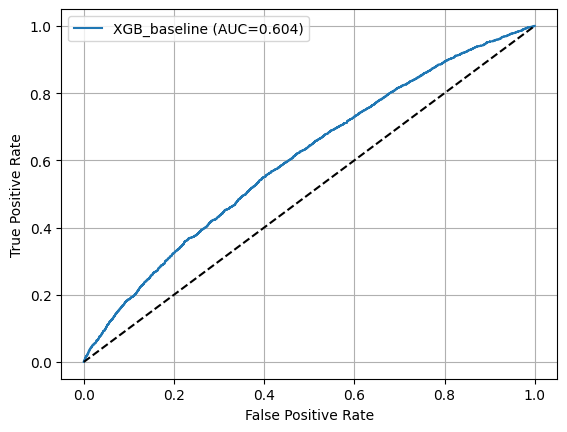

In [32]:
# 양성(사고 운전자) 비율로 scale_pos_weight 설정
pos_weight = (len(y_wo) - y_wo.sum()) / y_wo.sum()
print("scale_pos_weight:", pos_weight)

xgb_base = XGBClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1
)

xgb_base.fit(X_train, y_train)
base_result = evaluate_clf("XGB_baseline", xgb_base, X_train, y_train, X_valid, y_valid)


# 7. 성능 개선 XGBoost (강의 기준으로 튜닝)


===== XGB_tuned =====
Accuracy : 0.6943937582583527
Precision: 0.04371981930525988
Recall   : 0.4543982730706962
F1-score : 0.07976506252368322
ROC AUC  : 0.613755376007516
Confusion Matrix:
 [[43302 18417]
 [ 1011   842]]


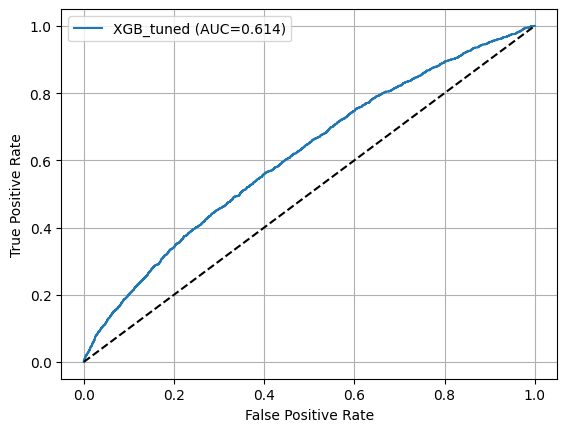

In [33]:
xgb_tuned = XGBClassifier(
    random_state=42,
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
    tree_method="hist",

    # 성능 개선용 하이퍼파라미터
    n_estimators=1200,
    learning_rate=0.03,

    max_depth=4,
    min_child_weight=5,
    gamma=0.1,

    subsample=0.8,
    colsample_bytree=0.8,

    reg_lambda=1.0,      # L2 정규화
    scale_pos_weight=pos_weight
)

xgb_tuned.fit(X_train, y_train)
tuned_result = evaluate_clf("XGB_tuned", xgb_tuned, X_train, y_train, X_valid, y_valid)


# 8. 최종 모델로 전체 데이터 학습 + 제출 파일 생성

In [34]:
# 어떤 모델이 더 좋은지 비교 (AUC 기준)
print("\nBaseline AUC:", base_result["auc"])
print("Tuned    AUC:", tuned_result["auc"])

best_model = xgb_tuned if tuned_result["auc"] >= base_result["auc"] else xgb_base
print("\n최종 선택 모델:", "XGB_tuned" if best_model is xgb_tuned else "XGB_baseline")

# 전체(이상치 제거된) 데이터로 재학습
best_model.fit(X_clean_wo, y_wo)

# 테스트 데이터 예측
test_proba = best_model.predict_proba(X_test_clean)[:, 1]

submission = pd.DataFrame({
    ID_COL: test[ID_COL],
    TARGET_COL: test_proba
})

submission.to_csv("submission_xgb_tuned.csv", index=False)
print("저장 완료: submission_xgb_tuned.csv")



Baseline AUC: 0.6041976130051399
Tuned    AUC: 0.613755376007516

최종 선택 모델: XGB_tuned
저장 완료: submission_xgb_tuned.csv


# 9. 지니계수

In [42]:
import numpy as np

def gini(actual, pred):
    """
    비정규화 Gini 계산 함수
    actual : 실제값(0/1)
    pred   : 예측 확률(0~1)
    """
    actual = np.asarray(actual)
    pred   = np.asarray(pred)

    # 예측값 기준 정렬
    order = np.argsort(pred)
    actual = actual[order]

    n = len(actual)
    cum_actual = np.cumsum(actual)

    gini_sum = cum_actual.sum() / cum_actual[-1] - (n + 1) / 2.0
    return gini_sum / n


def gini_normalized(actual, pred):
    """
    정규화 Gini
    """
    return gini(actual, pred) / gini(actual, actual)

In [43]:
valid_proba = xgb_model.predict_proba(X_valid)[:, 1]

In [44]:
gini_raw = gini(y_valid, valid_proba)
gini_norm = gini_normalized(y_valid, valid_proba)

print("Gini (raw):", gini_raw)
print("Gini (normalized):", gini_norm)

Gini (raw): -0.1834239841392089
Gini (normalized): 0.37786190702045686
